<a href="https://colab.research.google.com/github/macken1/chainer-mnist-docker/blob/master/BERT%E6%97%A5%E6%9C%AC%E8%AA%9E_%EF%BC%88encode_plus%E3%83%90%E3%83%BC%E3%82%B8%E3%83%A7%E3%83%B3%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BERTを使って文をベクトルで表現してみる**

In [22]:
## 以下、Mecabを入れとかないとTokenizerでエラーとなるのでインストールしておく
## 乾研のBERTではmecab-ipadic-2.7.0-20070801との要件になっているが、最新版をインストール。影響は不明
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3

E: dpkg was interrupted, you must manually run 'dpkg --configure -a' to correct the problem. 
E: dpkg was interrupted, you must manually run 'dpkg --configure -a' to correct the problem. 
W: Could not lock the cache file; this usually means that dpkg or another apt tool is already installing packages.  Opening in read-only mode; any changes you make to the states of packages will NOT be preserved!
E: dpkg was interrupted, you must manually run 'dpkg --configure -a' to correct the problem. 


## 1. 形態素解析（単語に分割する）ツールのMeCabをインストールする

Google colaboratory環境に、MeCab関連のツール（MeCab単体＋辞書、MeCabをpythonから実行）などをインストールします。

In [23]:
# coding: utf-8
# 念のため、形態素解析ができるかチェック

import MeCab

m = MeCab.Tagger("Owakati")
print(m.parse("私はKARAが大好きだった。コンサートに行ったころが懐かしい。"))
print(m.parse("コロナウイルスとプロスペクト理論に悩む今日この頃"))
print(m.parse("すもももももももものうち"))

私	名詞,代名詞,一般,*,*,*,私,ワタシ,ワタシ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
KARA	名詞,固有名詞,組織,*,*,*,*
が	助詞,格助詞,一般,*,*,*,が,ガ,ガ
大好き	名詞,形容動詞語幹,*,*,*,*,大好き,ダイスキ,ダイスキ
だっ	助動詞,*,*,*,特殊・ダ,連用タ接続,だ,ダッ,ダッ
た	助動詞,*,*,*,特殊・タ,基本形,た,タ,タ
。	記号,句点,*,*,*,*,。,。,。
コンサート	名詞,一般,*,*,*,*,コンサート,コンサート,コンサート
に	助詞,格助詞,一般,*,*,*,に,ニ,ニ
行っ	動詞,自立,*,*,五段・カ行促音便,連用タ接続,行く,イッ,イッ
た	助動詞,*,*,*,特殊・タ,基本形,た,タ,タ
ころ	名詞,非自立,副詞可能,*,*,*,ころ,コロ,コロ
が	助詞,格助詞,一般,*,*,*,が,ガ,ガ
懐かしい	形容詞,自立,*,*,形容詞・イ段,基本形,懐かしい,ナツカシイ,ナツカシイ
。	記号,句点,*,*,*,*,。,。,。
EOS

コロナ	名詞,一般,*,*,*,*,コロナ,コロナ,コロナ
ウイルス	名詞,一般,*,*,*,*,ウイルス,ウイルス,ウイルス
と	助詞,並立助詞,*,*,*,*,と,ト,ト
プロスペクト	名詞,固有名詞,一般,*,*,*,*
理論	名詞,一般,*,*,*,*,理論,リロン,リロン
に	助詞,格助詞,一般,*,*,*,に,ニ,ニ
悩む	動詞,自立,*,*,五段・マ行,基本形,悩む,ナヤム,ナヤム
今日	名詞,副詞可能,*,*,*,*,今日,キョウ,キョー
この	連体詞,*,*,*,*,*,この,コノ,コノ
頃	名詞,非自立,副詞可能,*,*,*,頃,コロ,コロ
EOS

すもも	名詞,一般,*,*,*,*,すもも,スモモ,スモモ
も	助詞,係助詞,*,*,*,*,も,モ,モ
もも	名詞,一般,*,*,*,*,もも,モモ,モモ
も	助詞,係助詞,*,*,*,*,も,モ,モ
もも	名詞,一般,*,*,*,*,もも,モモ,モモ
の	助詞,連体化,*,*,*,*,の,ノ,ノ
うち	名詞,非自立,副詞可能,*,*,*,うち,ウチ,ウチ
EOS



Colabでグラフ表示する際に文字化けしないように、必要なライブラリをインストールします

In [24]:
#　以下はmatplotlibでの日本語表示用のライブラリ
!pip install japanize_matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib 
import seaborn as sns

sns.set(font="IPAexGothic")

In [25]:
!pip install transformers
import torch
from transformers import BertJapaneseTokenizer, BertForMaskedLM
import transformers as ppb

# 東北大学乾研が作成した学習済みの日本語BERTモデルの形態素解析モデルを搭載します。
tokenizer = BertJapaneseTokenizer.from_pretrained('bert-base-japanese-whole-word-masking')

参照用にBERTモデル内の語彙（形態素）をvocabulary.txtに書き出します。<br>左のウインドウからvocabulary.txtをダブルクリックすると内容が確認できます。

In [0]:
# write all tokens in vocabulary.txt, which you can find on the left-hand side
with open("vocabulary.txt", 'w') as f:
    
    # For each token...
    for token in tokenizer.vocab.keys():
        
        # Write it out and escape any unicode characters.            
        f.write(token + '\n')


辞書に含まれている形態素の長さ（＝文字カウント）について分布をみてみます

最大の形態素長: 14


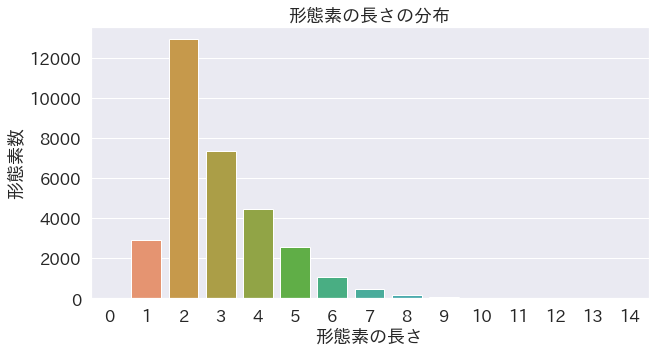

In [27]:
import numpy as np

sns.set(style='darkgrid',font="IPAexGothic")

# Increase the plot size and font size.
sns.set(font_scale=1.5,font="IPAexGothic")
plt.rcParams["figure.figsize"] = (10,5)

# Measure the length of every token in the vocab.
token_lengths = [len(token) for token in tokenizer.vocab.keys()]

# Plot the number of tokens of each length.
sns.countplot(token_lengths)
plt.title('形態素の長さの分布')
plt.xlabel('形態素の長さ')
plt.ylabel('形態素数')

print('最大の形態素長:', max(token_lengths))

文のベクトルを使って似た文を抽出してみましょう
せっかくなので、たくさんの文章からベクトル化を使って意味の似た文章を抽出してみましょう。  
まず、データを用意します。  
京都大学の黒橋・河原研究室のホームページ(※1)から「Textual Entailment 評価データ」をダウンロードしてデータファイルを作ります。
※１　https://bit.ly/2sXN2er

In [28]:
!wget http://nlp.ist.i.kyoto-u.ac.jp/nl-resource/rte/entail_evaluation_set.xml -P /content/

import xml.etree.ElementTree as ET
import codecs

# 出力するファイルを指定
f1 = codecs.open('T_plain.txt', 'w', 'utf-8')

# XMLファイルからT1とT2の正例を抽出して、ファイルに出力
corpus = ET.parse('entail_evaluation_set.xml')
root = corpus.getroot()

for child in root:
  grandchild_text = {}
  entail_tag = child.get('label')
  for grandchild in child.getchildren():
    grandchild_text[grandchild.tag] = grandchild.text
  if entail_tag == '◎' or entail_tag == '〇':
    f1.write(grandchild_text['t1']+"\n")
    f1.write(grandchild_text['t2']+"\n") 

--2020-04-11 05:33:13--  http://nlp.ist.i.kyoto-u.ac.jp/nl-resource/rte/entail_evaluation_set.xml
Resolving nlp.ist.i.kyoto-u.ac.jp (nlp.ist.i.kyoto-u.ac.jp)... 133.3.252.171
Connecting to nlp.ist.i.kyoto-u.ac.jp (nlp.ist.i.kyoto-u.ac.jp)|133.3.252.171|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 461805 (451K) [text/xml]
Saving to: ‘/content/entail_evaluation_set.xml.4’

entail_evaluation_s 100%[===================>] 450.98K   197KB/s    in 2.3s    

2020-04-11 05:33:16 (197 KB/s) - ‘/content/entail_evaluation_set.xml.4’ saved [461805/461805]



どんな文が含まれているのか、10個ほどサンプリングして表示してみます

In [29]:
import pandas as pd
df = pd.read_table("/content/T_plain.txt", header=None)
df.sample(10)

,0
94,昔は天動説が信じられていた。
417,角館は東北にある。
29,花子はお菓子が好きだ。
1370,売れ残ると困るので、店のお惣菜は夕方になると安くなる。
206,枝豆を食べた。
927,和歌を作った。
306,もみじ狩りに行った。
1034,化粧は女を化かす。
366,台風７号が発生し、日本に接近の恐れ。
114,郵便局は銀行の左隣りにあります。


文例をいったんリスト化します。

In [30]:
sentences = df[0].values
print(sentences)

['あの人は呼吸器専門医だ。' 'あの人は医者だ。' 'アメリカンショートヘアーを飼っている。' ...
 'ボジョレ・ヌーヴォーの販売には解禁日がある。' '彼は英語が堪能である。' '彼の英語はうまい。']


実際に、日本語の文章がどのように形態素、さらにBERTの分析用のIDに変換されるのかを見てみてましょう

In [31]:
# Print the original sentence.
print('原文: ', sentences[0])

# Print the sentence split into tokens.
print('形態素: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('形態素に対応するID番号化: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

原文:  あの人は呼吸器専門医だ。
形態素:  ['あの', '人', 'は', '呼吸', '器', '専門', '##医', 'だ', '。']
形態素に対応するID番号化:  [7755, 53, 9, 9489, 1777, 1534, 29205, 75, 8]


文をBERTで分析する際、入力側の形態素数（≒単語数）を固定する必要があります。

「Textual Entailment 評価データ」の形態素の数を見てみましょう。

※CLS、SEPなどの特別な形態素も含めてカウントしています

In [32]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('最長の形態素数は⇒ ', max_len)

最長の形態素数は⇒  29


BERTモデルを読み込みます。

In [33]:
from transformers import BertJapaneseTokenizer, BertModel

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-japanese-whole-word-masking')

# Set the model in evaluation mode to deactivate the DropOut modules
# This is IMPORTANT to have reproducible results during evaluation!
# どうもpytorchには学習モードと推論モードがあるらしい。以下は推論モードに切り替え
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

文例を一気に形態素の順にID化します。ここでは同時に短い文例は32形態素になるよう０で残りを埋めています。

In [34]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 32,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('attention_masks:', attention_masks[0])

Original:  あの人は呼吸器専門医だ。
Token IDs: tensor([    2,  7755,    53,     9,  9489,  1777,  1534, 29205,    75,     8,
            3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])
attention_masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


ID化した文例をBERTモデルを使って形態素ごとにベクトル化し、アウトプットのテンソルの次元を確認します

In [35]:
# GPU上で走らせるためには、関連するものをすべてGPU上に配置
input_ids = input_ids.to('cuda')
attention_masks = attention_masks.to('cuda')
model.to('cuda')

# いよいよ推論させる、というか各形態素に対応するベクトルを計算
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_masks)
# 以下で素のアウトプット
last_hidden_states = outputs[0]
last_hidden_states.shape
# last_hidden_states.type

torch.Size([1848, 32, 768])

吐き出したテンソルのうち、CLSに相当するテンソルのみ切り出します

In [36]:
# NumPy配列ndarrayの要素や部分配列（行・列など）は[2, 3, 1, ...]のように各次元の位置や範囲をカンマ区切りで指定。[:,0,:]でCLSに対応するはず
last_hidden_states[:,0,:].shape

torch.Size([1848, 768])

例に似た文章をコサイン類似度を使って似ている順番に抽出します。まず、形態素×ID化

In [37]:
# 例文と類似する文を探してみる
example = '猫がニャーニャーとうるさくて眠れない。'

# encode_plusでpaddingまでできる。超便利。ptでPyTorch、tfでTensorflow、何もつけないと普通にリストを返す
example_ids = tokenizer.encode_plus(example, max_length=32, pad_to_max_length=True, return_tensors='pt')
print(example_ids)
type(example_ids)
print(example_ids["input_ids"]) #辞書から必要な部分を参照

{'input_ids': tensor([[    2,  6040,    14,   353,   556,  5452, 28451,    13,  5619, 26079,
            16,  8263, 28461,    80,     8,     3,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}
tensor([[    2,  6040,    14,   353,   556,  5452, 28451,    13,  5619, 26079,
            16,  8263, 28461,    80,     8,     3,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])


そのうえで、BERTを使ってベクトル化します。

In [38]:
# GPU上で走らせるためには、関連するものをすべてGPU上に配置
input_ids_example = example_ids["input_ids"].to('cuda')
attention_masks_example = example_ids["attention_mask"].to('cuda')
model.to('cuda')

# いよいよ推論させる、というか各形態素に対応するベクトルを計算
with torch.no_grad():
    example_outputs = model(input_ids_example, attention_mask=attention_masks_example)
# 以下で素のアウトプット
last_hidden_states_example = example_outputs[0]
last_hidden_states_example[:,0,:].shape
# last_hidden_states.type

torch.Size([1, 768])

コサイン類似度をすべて文例と計算し、上位20例を表示します

In [39]:
corpus = codecs.open('/content/T_plain.txt', 'r', 'utf-8')
corpussimdic = {}

# コサイン類似度を計算する
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# 例文のベクトル
example_vec = last_hidden_states_example[:,0,:].to('cpu').detach().numpy().copy()

# コーパス文のベクトル
corpus_vec = last_hidden_states[:,0,:].to('cpu').detach().numpy().copy() 
  
print()
print(example, "<=>")

#
# コーパスの文とのコサイン類似度を求める
#
i = 0
for sentence in corpus:

  corpussimdic[sentence.rstrip('\n')] = cos_sim(example_vec, corpus_vec[i,:])
  i += 1


# valueで降順にソートしてトップ20の類似文を表示する
count = 0
for k, v in sorted(corpussimdic.items(), key=lambda x: -x[1]):
    print(str(v) + ": " + str(k)) 
    count += 1 
    if count == 20:
      break



猫がニャーニャーとうるさくて眠れない。 <=>
[1.0000001]: 猫がニャーニャーとうるさくて眠れない。
[0.94120175]: ニャーニャーとうるさくて眠れない。
[0.8842278]: 何をやっても眠けがとれない。
[0.87973124]: 何をしても眠い。
[0.86993796]: おたふく風邪にかかると困る。
[0.86776257]: あまりに眠くて、仕事にならない。
[0.8653278]: ラブバードを見ていると、心がなごむ。
[0.8635006]: ぼけると困る。
[0.8615057]: ぴょんぴょん飛び跳ねるのはウサギだけではない。
[0.8606796]: お昼だというのに、おなかがすかない。
[0.855985]: 彼女は機嫌が悪い。
[0.84726477]: 風で帽子がとんだ。
[0.8444803]: おなかがすいた。
[0.8398719]: 彼女は部屋のインテリアを気にする。
[0.8396411]: 白い器に果物をのせているのが、おしゃれだ。
[0.83810174]: さつきは緑に囲まれたマンションに住めてうらやましい。
[0.8379033]: お金がない。
[0.83746374]: 昨晩のおかずは和食だった。
[0.83619326]: 彼女の夫は顔だちがいい。
[0.83542836]: 虐待と間違われるのが怖くて、子供を叱れない。
